# Attention Walmart Shoppers
### A Walmart retail analysis

The data was originally retrieved from:
 -   https://www.kaggle.com/rutuspatel/retail-analysis-with-walmart-sales-data
 - https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

### Data Dictionary

| Target       |  Data Type       | Description                     |
|--------------|------------------|---------------------------------|
| Weekly_Sales |   float64        | Sales in USD per week by store  |


| Column        |  Data Type       | Description                                      |  
|---------------|------------------|--------------------------------------------------|
| Store         |     int64        | unique identifier for store  (1-45)              |
| Date          |     object       | Date of transaction                              |
| Holiday_Flag  |     int64        | indicator of a Holiday week (boolean)            |
| Temperature   |     float64      | temperature in Farenheight                       |
| Fuel_Price    |     float64      | cost of fuel(in USD) in region                   |
| CPI           |     float64      | Prevailing consumer price index, cost of goods   |
| Unemployment  |     float64      | Prevailing unemployment rate                     |

## Goal:
- to predict weekly sales price for a store

## Think about...
- What is your goal?
- what is your TARGET? drivers for that target?
- what is one oberservation? what does one row from your dataset represent?

## Daily meetings
- standup doc
- shared knowledge doc

### Three important Questions
- what did you work on since we last talked?
- what are you planning on working on next?
- what are your blockers?

In [1]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#custom modules
import wrangle
import new_wrangle

#remove warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
#bring in walmart data using new_wrangle.py
df= new_wrangle.acquire_data()

In [3]:
#take a look
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315


In [4]:
#check for nulls, dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
 8   Type          6435 non-null   object 
 9   Size          6435 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 553.0+ KB


<hr style="border:2px solid black"> </hr>

# Prepare

In [5]:
#import the cleaned data using new_wrangle.py
df= new_wrangle.wrangle_walmart()

In [6]:
#make sure that all columns are created
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_id            6435 non-null   object 
 1   weekly_sales        6435 non-null   float64
 2   holiday_flag        6435 non-null   int64  
 3   temperature         6435 non-null   int64  
 4   fuel_price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   unemployment        6435 non-null   float64
 7   store_type          6435 non-null   object 
 8   store_size          6435 non-null   int64  
 9   month               6435 non-null   object 
 10  year                6435 non-null   int64  
 11  quarter             6435 non-null   int64  
 12  weekday             6435 non-null   object 
 13  week_of_year        6435 non-null   int64  
 14  deflated_series     6435 non-null   float64
 15  sales_delta_weekly  6435 non-null   f

In [7]:
#take a look at the data
df.tail()

,store_id,weekly_sales,holiday_flag,temperature,fuel_price,CPI,unemployment,store_type,store_size,month,...,gas_delta_weekly,gas_delta_yearly,last_year_sales,last_week_sales,season,holiday_name,christmas,labor_day,super_bowl,thanksgiving
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-26,25,688940.94,0,56,3.88,216.152,7.293,B,128107,October,...,-0.09,0.31,no_holiday,no_holiday,Fall,no_holiday,0,0,0,0
2012-10-26,5,319550.77,0,71,3.51,224.038,5.422,B,34875,October,...,-0.08,0.14,no_holiday,no_holiday,Fall,no_holiday,0,0,0,0
2012-10-26,40,921264.52,0,49,3.92,138.728,4.145,A,155083,October,...,-0.08,0.32,no_holiday,no_holiday,Fall,no_holiday,0,0,0,0
2012-10-26,18,1127516.25,0,56,3.92,138.728,8.243,B,120653,October,...,-0.08,0.32,no_holiday,no_holiday,Fall,no_holiday,0,0,0,0
2012-10-26,45,760281.43,0,58,3.88,192.309,8.667,B,118221,October,...,-0.09,0.31,no_holiday,no_holiday,Fall,no_holiday,0,0,0,0


In [ ]:
#sales from last year
df['last_year_sales'] = df.groupby('store_id').weekly_sales.shift(-52)
#sales for last week
df['last_week_sales'] = df.groupby('store_id').weekly_sales.shift(-1)

In [8]:
#train test split
train, test, X_train, y_train, X_test, y_test = new_wrangle.train_test(df,'weekly_sales')

train -> (4504, 27)
test -> (1931, 27)


In [9]:
y_train.head()

Date
2010-07-30     336378.38
2011-08-05     783614.89
2011-10-14    1378340.18
2010-03-19    1946875.06
2012-09-28     964726.37
Name: weekly_sales, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_id            6435 non-null   object 
 1   weekly_sales        6435 non-null   float64
 2   holiday_flag        6435 non-null   int64  
 3   temperature         6435 non-null   int64  
 4   fuel_price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   unemployment        6435 non-null   float64
 7   store_type          6435 non-null   object 
 8   store_size          6435 non-null   int64  
 9   month               6435 non-null   object 
 10  year                6435 non-null   int64  
 11  quarter             6435 non-null   int64  
 12  weekday             6435 non-null   object 
 13  week_of_year        6435 non-null   int64  
 14  deflated_series     6435 non-null   float64
 15  sales_delta_weekly  6435 non-null   f

<hr style="border:2px solid black"> </hr>

# Explore

In [11]:
df.head()

,store_id,weekly_sales,holiday_flag,temperature,fuel_price,CPI,unemployment,store_type,store_size,month,...,gas_delta_weekly,gas_delta_yearly,last_year_sales,last_week_sales,season,holiday_name,christmas,labor_day,super_bowl,thanksgiving
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1643690.90,0,42,2.57,211.096,8.106,A,151315,February,...,0.0,0.0,1.60663e+06,1.64196e+06,Winter,no_holiday,0,0,0,0
2010-02-05,10,2193048.75,0,54,2.96,126.442,9.765,B,126512,February,...,0.0,0.0,1.96805e+06,2.17603e+06,Winter,no_holiday,0,0,0,0
2010-02-05,37,536006.73,0,45,2.57,209.853,8.554,C,39910,February,...,0.0,0.0,583835,529853,Winter,no_holiday,0,0,0,0
2010-02-05,17,789036.02,0,23,2.67,126.442,6.548,B,93188,February,...,0.0,0.0,816603,841952,Winter,no_holiday,0,0,0,0
2010-02-05,30,465108.52,0,39,2.57,210.753,8.324,C,42988,February,...,0.0,0.0,490971,497375,Winter,no_holiday,0,0,0,0


In [12]:
#count of season
train.season.value_counts()

Summer    2050
Winter     946
Spring     830
Fall       678
Name: season, dtype: int64

In [13]:
#counts by holidays
train.holiday_name.value_counts()

no_holiday      4194
super_bowl        95
labor_day         89
thanksgiving      67
christmas         59
Name: holiday_name, dtype: int64

In [14]:
#counts by quarter
train.quarter.value_counts()

3    1258
2    1214
1    1051
4     981
Name: quarter, dtype: int64

## bivariate exploration

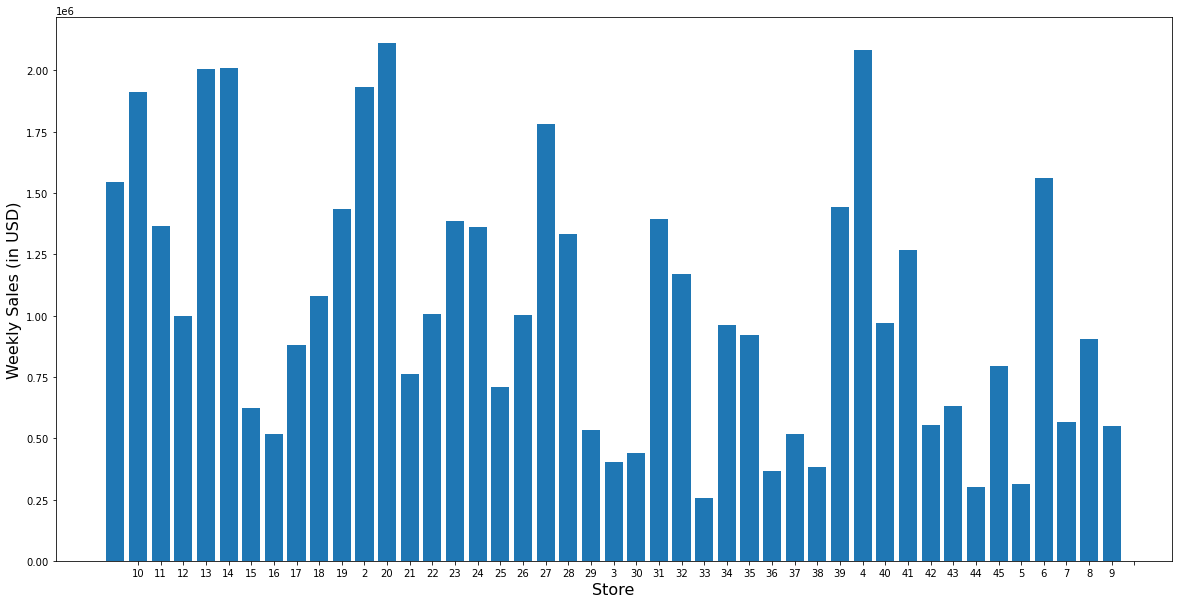

In [15]:
#average weekly sales by store
stores = train.groupby(['store_id']).agg({'weekly_sales': ['mean']})

plt.figure(figsize=(20, 10))
plt.bar(stores.index,stores['weekly_sales']['mean'])
plt.xticks(np.arange(1, 46, step=1))
plt.ylabel('Weekly Sales (in USD)', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

<AxesSubplot:xlabel='store_type', ylabel='store_size'>

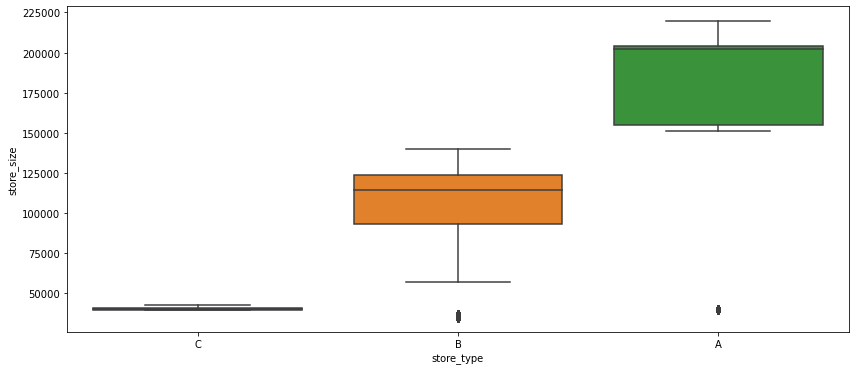

In [16]:
#visualize store_type by store_size
plt.figure(figsize=(14, 6))
sns.boxplot(x='store_type', y='store_size', data=train)

### Takeaways:
- Store A: appears to be only larger stores
- Store B: appear to be midsized stores
- Store C: appears to be only smaller stores

- outliers were addressed (store 3, store 5, store 33, store 36 were classified incorrectly)

In [ ]:
df['last_year_sales'] = df.groupby('store_id').weekly_sales.shift(periods=52)

<AxesSubplot:xlabel='store_type', ylabel='weekly_sales'>

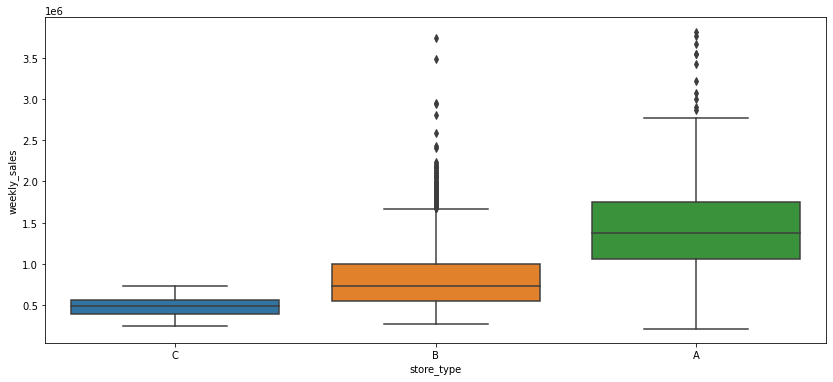

In [17]:
#visualize stores and weekly sales
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='weekly_sales', data=train)

<AxesSubplot:xlabel='store_type', ylabel='unemployment'>

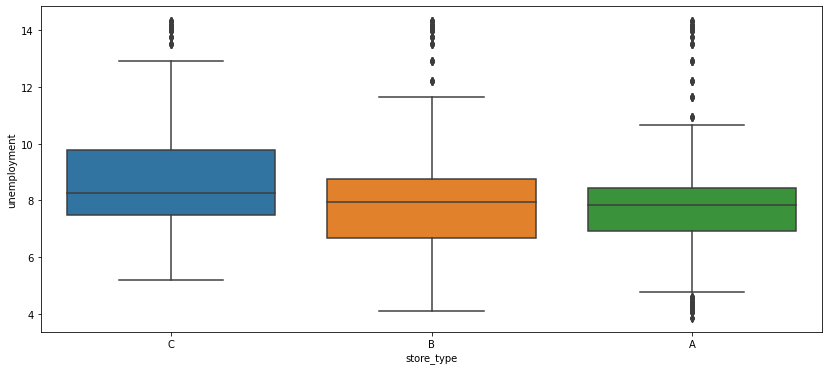

In [18]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='unemployment', data=train)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

store_id
1     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
15    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
17    AxesSubplot(0.125,0.125;0.775x0.755)
18    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
20    AxesSubplot(0.125,0.125;0.775x0.755)
21    AxesSubplot(0.125,0.125;0.775x0.755)
22    AxesSubplot(0.125,0.125;0.775x0.755)
23    AxesSubplot(0.125,0.125;0.775x0.755)
24    AxesSubplot(0.125,0.125;0.775x0.755)
25    AxesSubplot(0.125,0.125;0.775x0.755)
26    AxesSubplot(0.125,0.125;0.775x0.755)
27    AxesSubplot(0.125,0.125;0.775x0.755)
28    AxesSubplot(0.125,0.125;0.775x0.755)
29    AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
30

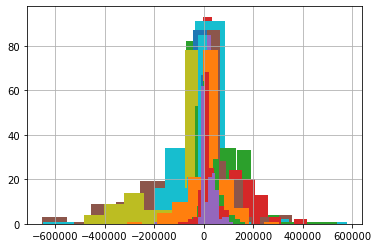

In [20]:
df.groupby('store_id').sales_delta_yearly.hist()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_id            6435 non-null   object 
 1   weekly_sales        6435 non-null   float64
 2   holiday_flag        6435 non-null   int64  
 3   temperature         6435 non-null   int64  
 4   fuel_price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   unemployment        6435 non-null   float64
 7   store_type          6435 non-null   object 
 8   store_size          6435 non-null   int64  
 9   month               6435 non-null   object 
 10  year                6435 non-null   int64  
 11  quarter             6435 non-null   int64  
 12  weekday             6435 non-null   object 
 13  week_of_year        6435 non-null   int64  
 14  deflated_series     6435 non-null   float64
 15  sales_delta_weekly  6435 non-null   f

<AxesSubplot:xlabel='fuel_price', ylabel='temperature'>

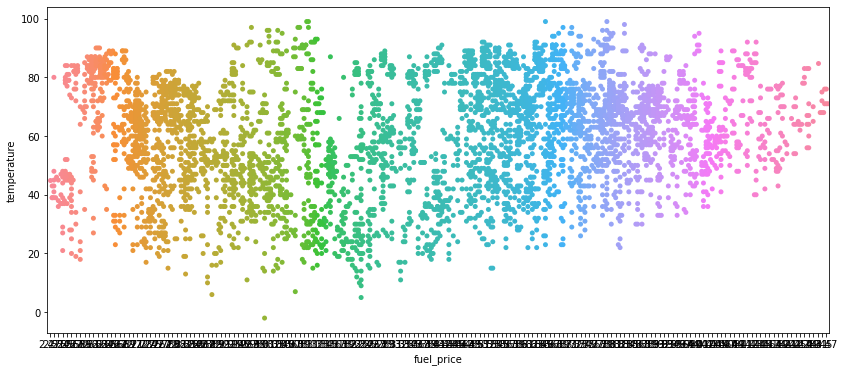

In [22]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='fuel_price', y='temperature', data=train)

<AxesSubplot:xlabel='fuel_price', ylabel='weekly_sales'>

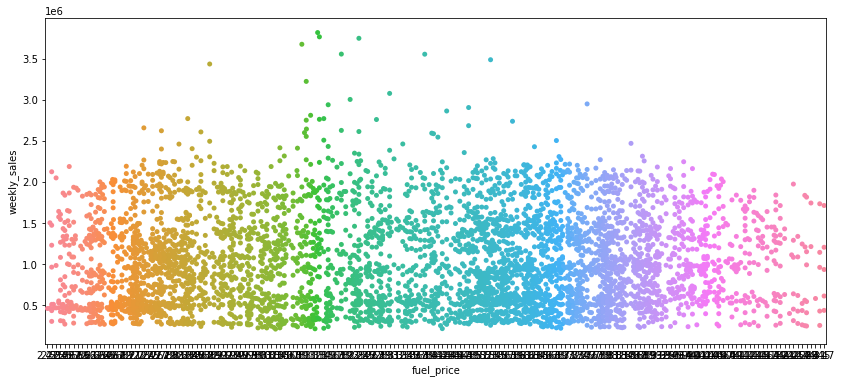

In [23]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='fuel_price', y='weekly_sales', data=train)

<AxesSubplot:xlabel='week_of_year', ylabel='weekly_sales'>

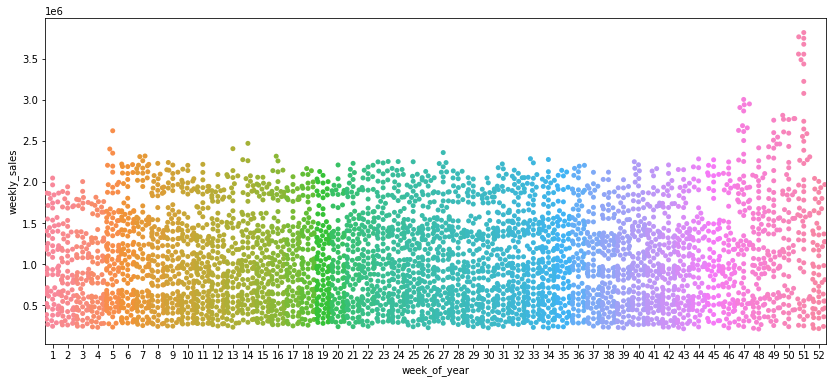

In [24]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='week_of_year', y='weekly_sales', data=train)

<AxesSubplot:xlabel='season', ylabel='weekly_sales'>

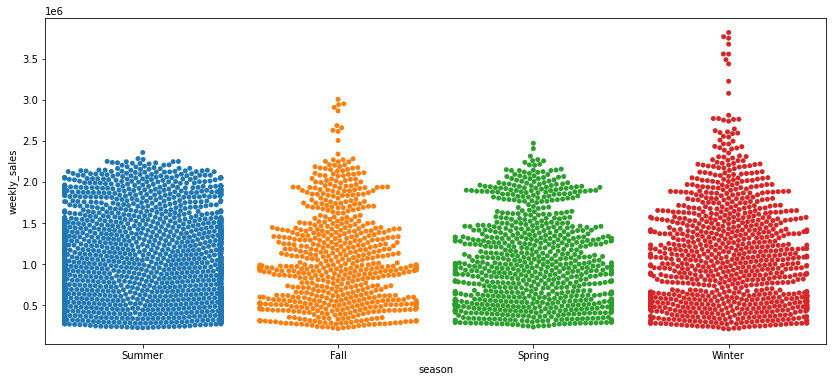

In [25]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='season', y='weekly_sales', data=train)

<AxesSubplot:xlabel='month', ylabel='weekly_sales'>

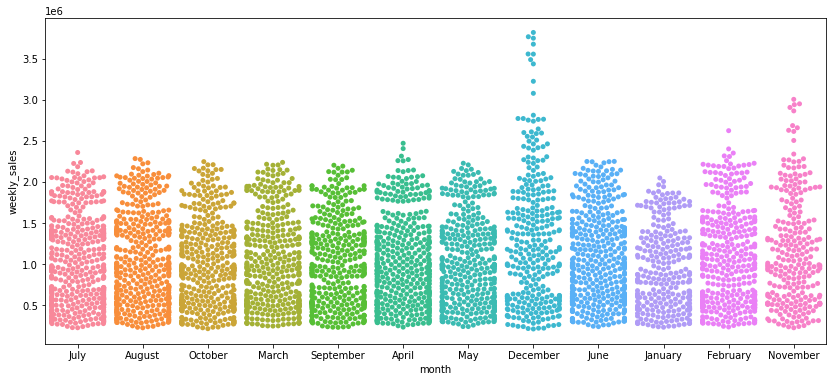

In [26]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='month', y='weekly_sales', data=train)

In [27]:
walmart = train.corr()
walmart

,weekly_sales,holiday_flag,temperature,fuel_price,CPI,unemployment,store_size,year,quarter,week_of_year,deflated_series,sales_delta_weekly,sales_delta_yearly,gas_delta_weekly,gas_delta_yearly,christmas,labor_day,super_bowl,thanksgiving
weekly_sales,1.000000,0.049335,-0.059755,0.017789,-0.079903,-0.105720,0.807157,-0.016689,0.060105,0.074466,0.906224,0.139101,0.067596,-0.032381,0.004431,-0.008127,0.015903,0.004721,0.086918
holiday_flag,0.049335,1.000000,-0.160212,-0.074254,0.001335,0.005056,0.007669,-0.051860,0.079026,0.124311,0.042902,-0.078672,0.058476,0.012090,-0.015415,0.423763,0.522231,0.539915,0.451987
temperature,-0.059755,-0.160212,1.000000,0.149506,0.182890,0.106928,-0.092401,0.064569,0.250542,0.242875,-0.109724,0.028344,0.000033,-0.166422,0.070621,-0.155737,0.103992,-0.198966,-0.072158
fuel_price,0.017789,-0.074254,0.149506,1.000000,-0.163364,-0.035505,0.014623,0.776985,-0.039603,-0.026127,0.068091,0.016567,0.017625,0.053293,0.542467,-0.045116,0.032575,-0.083145,-0.051669
CPI,-0.079903,0.001335,0.182890,-0.163364,1.000000,-0.297058,-0.021960,0.089538,-0.005791,-0.002414,-0.438467,0.008870,0.036328,-0.031427,-0.011165,-0.011783,0.007609,-0.005871,0.012080
unemployment,-0.105720,0.005056,0.106928,-0.035505,-0.297058,1.000000,-0.088986,-0.244931,-0.018816,-0.018966,-0.016022,-0.002282,-0.141533,0.017620,0.020769,-0.006945,-0.007894,0.014212,0.009302
store_size,0.807157,0.007669,-0.092401,0.014623,-0.021960,-0.088986,1.000000,0.003881,0.000664,0.003846,0.695558,-0.003448,0.060699,-0.016325,0.009991,0.000222,0.015840,-0.000055,-0.002317
year,-0.016689,-0.051860,0.064569,0.776985,0.089538,-0.244931,0.003881,1.000000,-0.185761,-0.179693,-0.043369,0.019504,0.128192,0.035761,0.139078,-0.059077,0.019655,-0.003844,-0.071002
quarter,0.060105,0.079026,0.250542,-0.039603,-0.005791,-0.018816,0.000664,-0.185761,1.000000,0.964226,0.058049,0.002377,0.034147,-0.186309,0.015915,0.162991,0.068580,-0.202625,0.173847
week_of_year,0.074466,0.124311,0.242875,-0.026127,-0.002414,-0.018966,0.003846,-0.179693,0.964226,1.000000,0.069365,-0.024707,0.035529,-0.206907,0.018159,0.213821,0.102796,-0.205256,0.184595


In [28]:
#this shows correlation with sales
wal_corr = walmart['weekly_sales'].sort_values(ascending=False)
wal_corr

weekly_sales          1.000000
deflated_series       0.906224
store_size            0.807157
sales_delta_weekly    0.139101
thanksgiving          0.086918
week_of_year          0.074466
sales_delta_yearly    0.067596
quarter               0.060105
holiday_flag          0.049335
fuel_price            0.017789
labor_day             0.015903
super_bowl            0.004721
gas_delta_yearly      0.004431
christmas            -0.008127
year                 -0.016689
gas_delta_weekly     -0.032381
temperature          -0.059755
CPI                  -0.079903
unemployment         -0.105720
Name: weekly_sales, dtype: float64

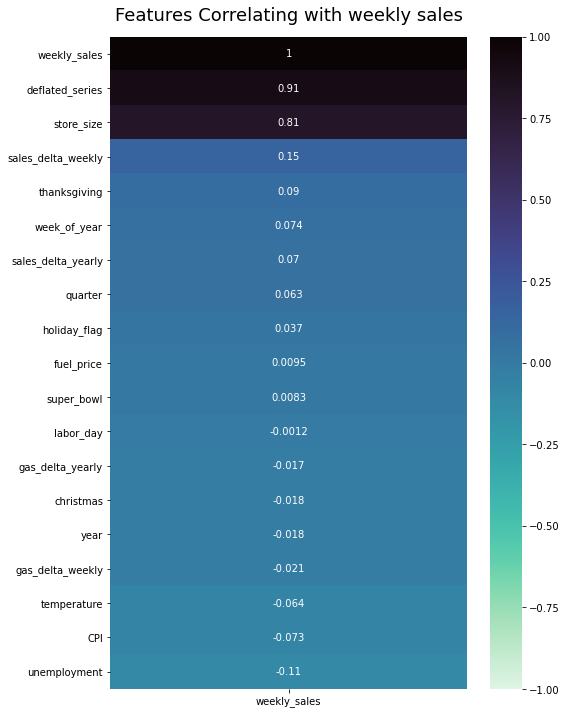

In [29]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['weekly_sales']].sort_values(by='weekly_sales', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with weekly sales', fontdict={'fontsize':18}, pad=16);

<hr style="border:2px solid black"> </hr>

## Hypothesis 1: Pearson's (cont vs cont)
$H_0$: There is no correlation between weekly_sales and store_size

$H_a$: There is a correlation between weekly_sales and store_size


In [30]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

In [31]:
x= train.weekly_sales
y= train.store_size

In [32]:
r, p = stats.pearsonr(x,y)
r,p

(0.8071568233580177, 0.0)

In [33]:
p < alpha

True

In [34]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.807157 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


<hr style="border:2px solid black"> </hr>

## Hypothesis 2: Pearson's (cont vs cont)
$H_0$: There is no correlation between weekly_sales and temperature

$H_a$: There is a correlation between weekly_sales and temperature

In [35]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

x= train.weekly_sales
y= train.temperature

In [36]:
r, p = stats.pearsonr(x,y)
r,p

(-0.0597553818296583, 6.001118597130992e-05)

In [37]:
p < alpha

True

In [38]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of -0.059755 and a statistical certainty p of 0.000060
Because p 0.000060 < α  0.050000, we can reject our null hypothesis


<hr style="border:2px solid black"> </hr>

## Hypothesis 3: T-Test (cont vs discrete)¶
$H_0$: There is no relationship between weekly_sales and week_of_year

$H_a$: There is a relationship between weekly_sales and week_of_year

In [39]:
#set alpha
alpha = .05

In [40]:
# sample size, must be more then 30 to meet assumption
train.weekly_sales.count(), train.week_of_year.count()

(4504, 4504)

In [41]:
#check variance
train.weekly_sales.var(), train.week_of_year.var()

#this shows not equal varient

(317035543065.2781, 199.85473701368983)

In [42]:
#t-test on entire train set
t, p = stats.ttest_ind(train.weekly_sales,train.week_of_year, equal_var=False)
t,p

(125.38803140178173, 0.0)

In [43]:
p <alpha

True

In [44]:
print(f'We calculate a t of {t:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we reject our null hypothesis')

We calculate a t of 125.388031 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we reject our null hypothesis


<hr style="border:2px solid black"> </hr>

# Clustering
- we are clustering in order to attempt to find regions

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

### Cluster 1: CPI & Fuel Prices

In [46]:
#chose variables for this possible cluster
X = train[['CPI', 'fuel_price']]
#tke a look
X.head()

,CPI,fuel_price
Date,,
2010-07-30,126.107,3.02
2011-08-05,215.198,3.68
2011-10-14,217.005,3.27
2010-03-19,126.607,3.05
2012-09-28,138.740,4.02


In [47]:
# Scale the X
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

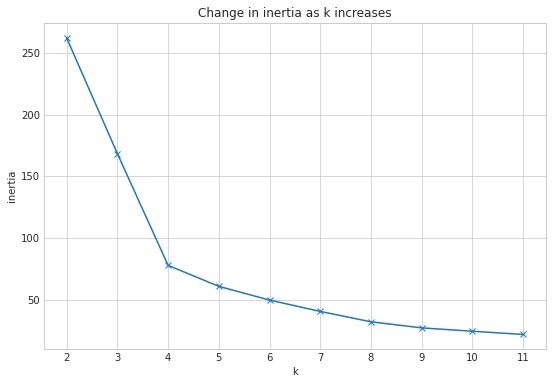

In [48]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [49]:
def scatter_plots(X_scaled, col_name= 'column_one', col_name_two= 'column_two'):
    '''
    This function takes in two columns and 
    creates a range of scatter plots based on varying k values
    '''
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    for ax, k in zip(axs.ravel(), range(2, 6)):
        clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
        ax.scatter(X_scaled[col_name], X_scaled[col_name_two], c=clusters)
        ax.set(title='k = {}'.format(k), xlabel=col_name, ylabel=col_name_two)


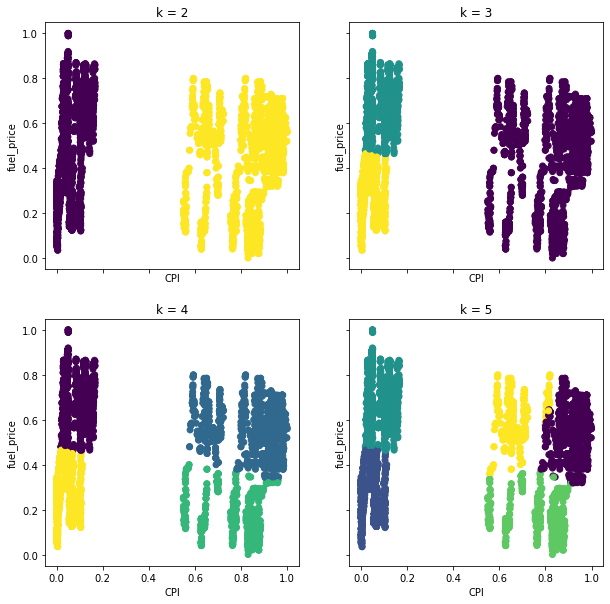

In [50]:
#use scatter_plot function 
#this will show you different clusters with varying k values
scatter_plots(X_scaled, col_name= 'CPI', col_name_two= 'fuel_price')

### Cluster 1 Takeaways
- k = 4 appears to show best results
- cluster 1 (blue): lower CPI, low fuel prices
- cluster 2 (green): high fuel prices, low CPI
- cluster 3 (purple): high CPI, low fuel prices
- cluster 4 (yellow): high CPI, high fuel prices

<hr style="border:1px solid black"> </hr>

## Cluster 2: CPI & Unemployment

In [51]:
#chose variables for this possible cluster
X2 = train[['CPI', 'unemployment']]
#tke a look
X2.head()

,CPI,unemployment
Date,,
2010-07-30,126.107,14.180
2011-08-05,215.198,7.852
2011-10-14,217.005,7.441
2010-03-19,126.607,9.765
2012-09-28,138.740,7.405


In [52]:
# Scale the X
scaler = MinMaxScaler().fit(X2)
X2_scaled = pd.DataFrame(scaler.transform(X2), columns= X2.columns).set_index([X2.index.values])

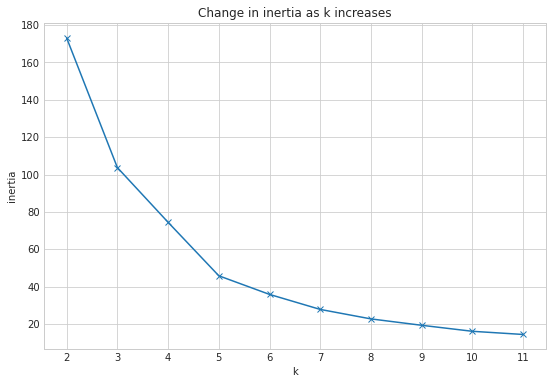

In [53]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

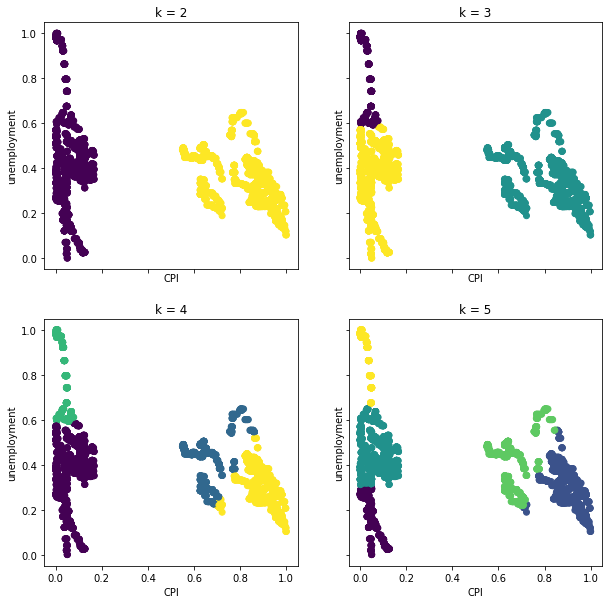

In [54]:
#use scatter_plot function 
#this will show you different clusters with varying k values
scatter_plots(X2_scaled, col_name= 'CPI', col_name_two= 'unemployment')

### Cluster 2 Takeaways
- k = 3 appears to show best results
- cluster 1 (purple): low unemployment, low cpi
- cluster 2 (yellow): high unemployment, low cpi
- cluster 3 (teal): high cpi, mid unemployment

<hr style="border:1px solid black"> </hr>

## Cluster 3: Temperature & Unemployment

In [55]:
#chose variables for this possible cluster
X3 = train[['temperature', 'unemployment']]
#tke a look
X3.head()

,temperature,unemployment
Date,,
2010-07-30,96,14.180
2011-08-05,94,7.852
2011-10-14,69,7.441
2010-03-19,61,9.765
2012-09-28,50,7.405


In [56]:
# Scale the X
scaler = MinMaxScaler().fit(X3)
X3_scaled = pd.DataFrame(scaler.transform(X3), columns= X3.columns).set_index([X3.index.values])

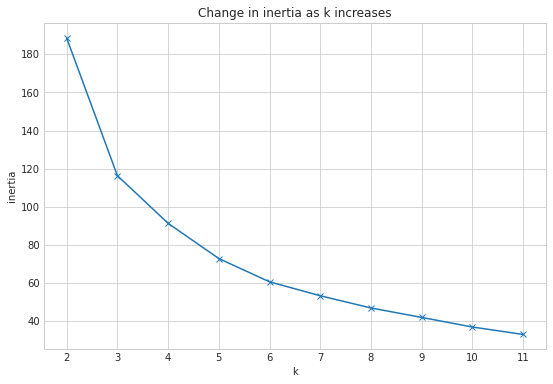

In [57]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

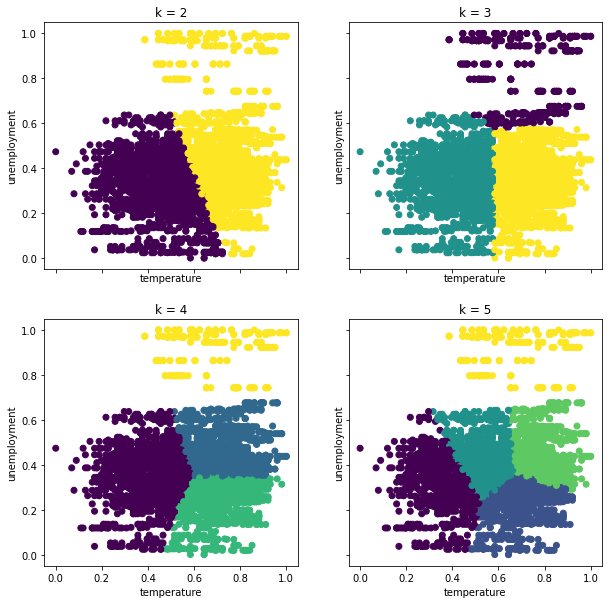

In [58]:
#use scatter_plot function 
#this will show you different clusters with varying k values
scatter_plots(X3_scaled, col_name= 'temperature', col_name_two= 'unemployment')

### Cluster 3 Takeaways
- k = 3 appears to show best results
- cluster 1 (green): lower temps, low- mid unemployment
- cluster 2 (purple): high temp, low-mid unemployment
- cluster 3 (yellow): high unemployment, mid-high temps 

<hr style="border:1px solid black"> </hr>

## Cluster 4: Temperature & Gas Prices

In [59]:
#chose variables for this possible cluster
X4 = train[['temperature', 'fuel_price']]
#tke a look
X4.head()

,temperature,fuel_price
Date,,
2010-07-30,96,3.02
2011-08-05,94,3.68
2011-10-14,69,3.27
2010-03-19,61,3.05
2012-09-28,50,4.02


In [60]:
# Scale the X
scaler = MinMaxScaler().fit(X4)
X4_scaled = pd.DataFrame(scaler.transform(X4), columns= X4.columns).set_index([X4.index.values])

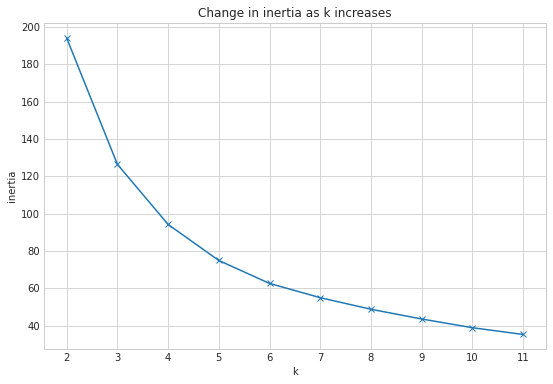

In [61]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X4_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

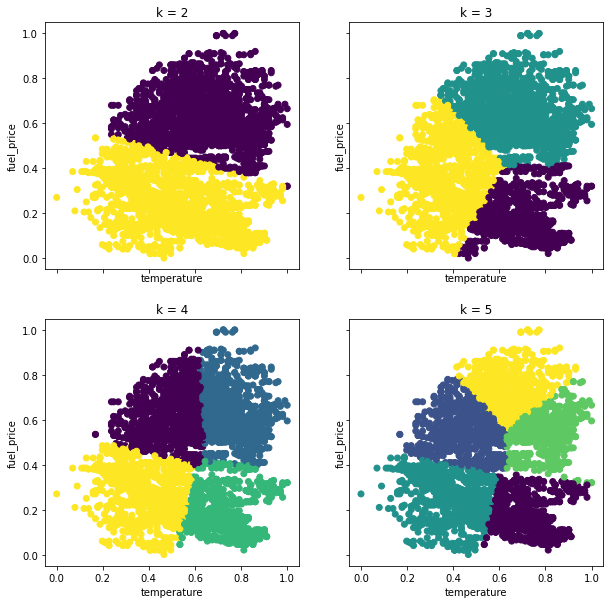

In [62]:
#use scatter_plot function 
#this will show you different clusters with varying k values
scatter_plots(X4_scaled, col_name= 'temperature', col_name_two= 'fuel_price')

### Cluster 4 Takeaways
- k = 4 appears to show best results
- cluster 1 (green): lower temps, low fuel prices
- cluster 2 (blue): high temp, low fuel prices
- cluster 3 (yellow): high fuel prices, low temps 
- cluster 4 (purple): high temps, high fuel prices

<hr style="border:2px solid black"> </hr>

# Modeling

In [63]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame({'actual': y_train})
y_test = pd.DataFrame({'actual': y_test})

## Baseline

In [64]:
#create the baseline
baseline= y_train['actual'].mean()

In [65]:
#create column called baseline to compare
y_train['baseline'] = baseline

In [66]:
#calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [67]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': round(rmse_baseline_train, 5)
}])

metric_df
#we now have out baseline model to work off of

,model,rmse_train
0,mean_baseline,562996.58373


In [68]:
## RFE
## select K Best

In [69]:
X_train.columns

Index(['store_id', 'holiday_flag', 'temperature', 'fuel_price', 'CPI',
       'unemployment', 'store_type', 'store_size', 'month', 'year', 'quarter',
       'weekday', 'week_of_year', 'deflated_series', 'sales_delta_weekly',
       'sales_delta_yearly', 'gas_delta_weekly', 'gas_delta_yearly',
       'last_year_sales', 'last_week_sales', 'season', 'holiday_name',
       'christmas', 'labor_day', 'super_bowl', 'thanksgiving'],
      dtype='object')

In [70]:
#set features
#we do not want to include all columns in this because it could cause overfitting
features = ['store_size', 'unemployment', 'week_of_year', 'sales_delta_weekly']

## OLS Model

In [71]:
#ordinary least squares
#create the model 
model1 = LinearRegression(normalize=True)

#fit the model
model1.fit(X_train[features], y_train.actual)

LinearRegression(normalize=True)

In [72]:
# predict train
y_train['sales_pred_lm'] = model1.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.sales_pred_lm)**(1/2)

In [73]:
#create visual to see baseline vs LinearRegression model
metric_df = metric_df.append(
    {
    'model': 'Model 1: OLS',
    'rmse_train': round(rmse_train, 5),
    }, ignore_index=True)

metric_df

,model,rmse_train
0,mean_baseline,562996.58373
1,Model 1: OLS,319332.43627


## Lasso Lars

In [74]:
# create the model object
model2 = LassoLars(alpha= 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
model2.fit(X_train[features], y_train.actual)

# predict train
y_train['sales_pred_lars'] = model2.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.sales_pred_lars)**(1/2)

In [75]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 2: LassoLars (alpha 2)',
    'rmse_train': round(rmse_train,5),
    }, ignore_index=True)

metric_df

,model,rmse_train
0,mean_baseline,562996.58373
1,Model 1: OLS,319332.43627
2,Model 2: LassoLars (alpha 2),319332.54480


## Polynomial Regression

In [76]:
#make the polynomial features to get a new set of features
model3 = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = model3.fit_transform(X_train[features])


In [77]:
#create the model
lm2 = LinearRegression(normalize=True)

#fit the mode
lm2.fit(X_train_degree2, y_train.actual)

#use the model
y_train['sale_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_model3 = mean_squared_error(y_train.actual, y_train.sale_pred_lm2) ** (1/2)

In [78]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 3: Polynomial Regression (degree=2)',
    'rmse_train': round(rmse_train_model3,5),
    }, ignore_index=True)

metric_df

,model,rmse_train
0,mean_baseline,562996.58373
1,Model 1: OLS,319332.43627
2,Model 2: LassoLars (alpha 2),319332.54480
3,Model 3: Polynomial Regression (degree=2),292925.96702
